# Task 2 — Exploratory Data Analysis

In [80]:
# Imports and setup
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# Add src to path for imports
sys.path.insert(0, "../")

from src.utils.plotter import Plotter

# Initialize plotter
plotter = Plotter()

In [81]:
# Load enriched data
df = pd.read_csv("../data/processed/ethiopia_fi_unified_data_enriched.csv")
ref_df = pd.read_excel("../data/raw/reference_codes.xlsx")

print(f"Loaded {len(df)} records from enriched dataset")
print(f"Loaded {len(ref_df)} records from reference codes")

# Convert dates
df['observation_date'] = pd.to_datetime(df['observation_date'], errors='coerce')
df['collection_date'] = pd.to_datetime(df['collection_date'], errors='coerce')

Loaded 46 records from enriched dataset
Loaded 71 records from reference codes


C:\Users\dell\AppData\Local\Temp\ipykernel_31792\145916869.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['collection_date'] = pd.to_datetime(df['collection_date'], errors='coerce')


Record types:
record_type
observation    31
event          11
target          3
impact_link     1
Name: count, dtype: int64


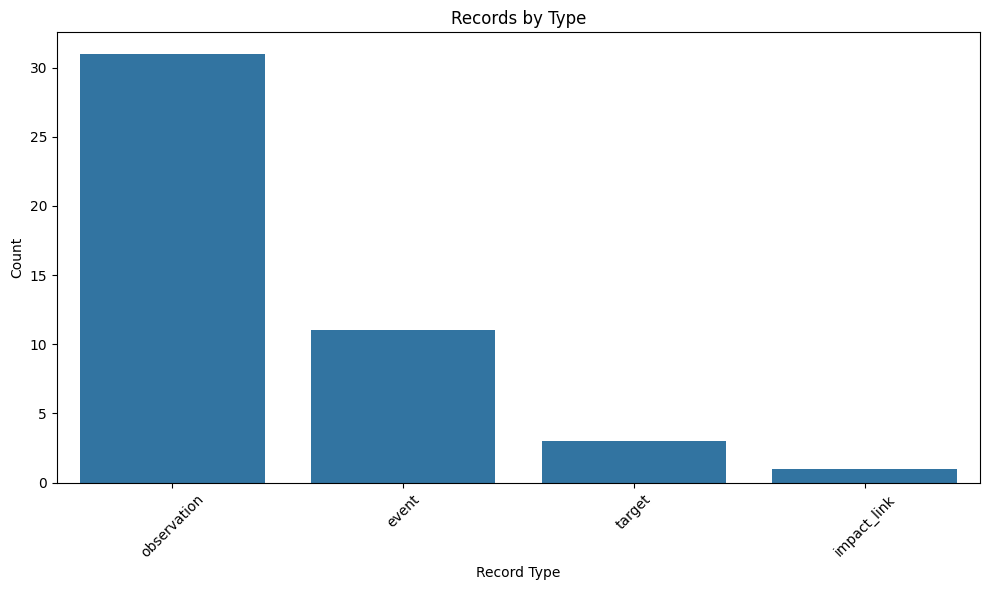


Pillars:
pillar
ACCESS           16
USAGE            11
None             11
GENDER            5
AFFORDABILITY     1
usage             1
access            1
Name: count, dtype: int64


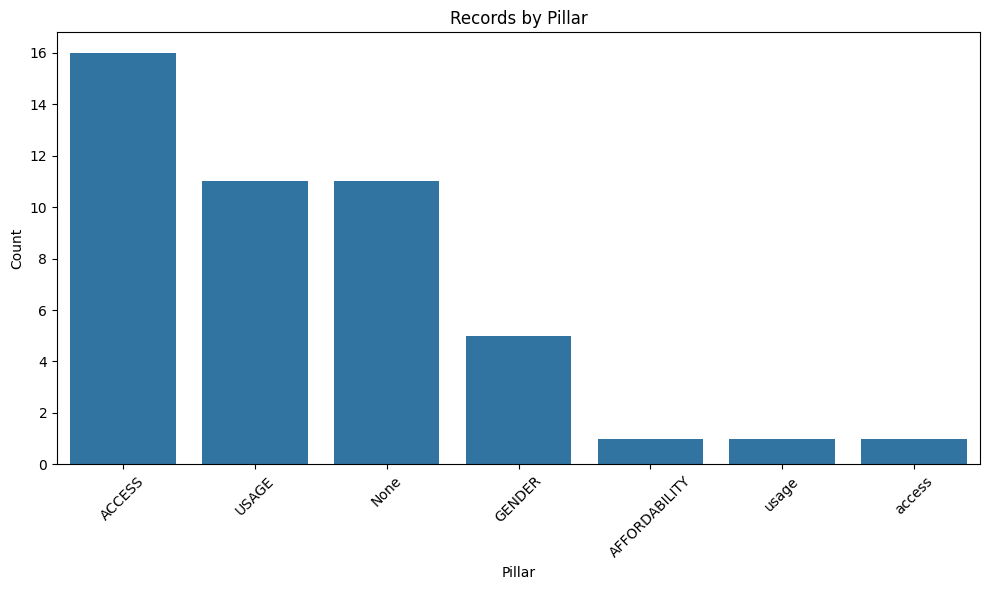


Source types:
source_type
operator      15
survey        10
regulator      7
research       4
policy         3
None           3
calculated     2
news           2
Name: count, dtype: int64


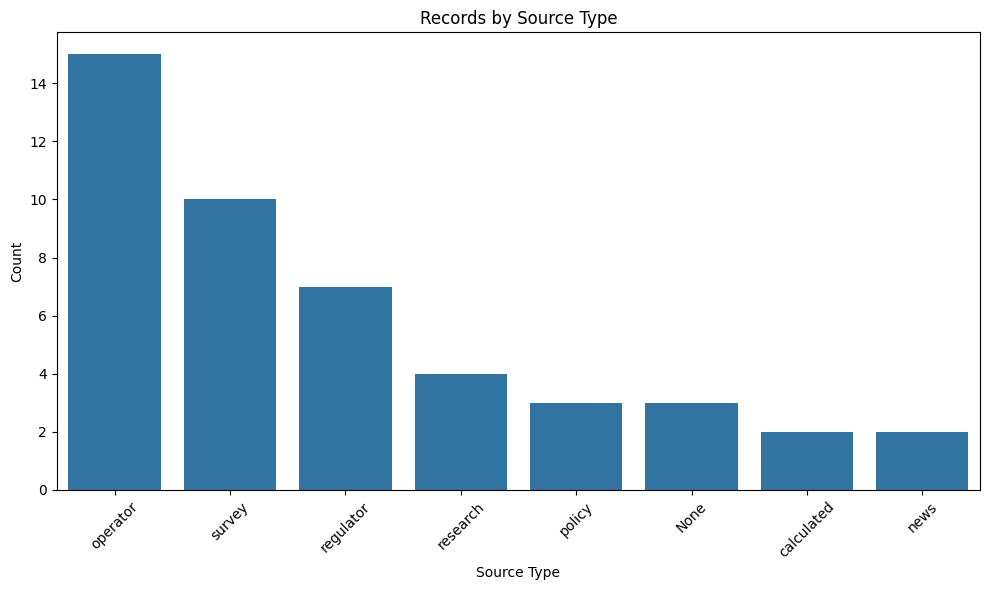

In [82]:
## Dataset Overview

### Summary by record_type, pillar, and source_type
record_counts = df['record_type'].value_counts()
pillar_counts = df['pillar'].fillna('None').value_counts()
source_counts = df['source_type'].fillna('None').value_counts()

print("Record types:")
print(record_counts)
df_record = record_counts.reset_index(name='count')
plotter.plot_bar(df_record, x='record_type', y='count', title='Records by Type', xlabel='Record Type', ylabel='Count')

print("\nPillars:")
print(pillar_counts)
df_pillar = pillar_counts.reset_index(name='count')
plotter.plot_bar(df_pillar, x='pillar', y='count', title='Records by Pillar', xlabel='Pillar', ylabel='Count')

print("\nSource types:")
print(source_counts)
df_source = source_counts.reset_index(name='count')
plotter.plot_bar(df_source, x='source_type', y='count', title='Records by Source Type', xlabel='Source Type', ylabel='Count')

Temporal coverage (count of observations per indicator per year):
year                2014.0  2017.0  2021.0  2023.0  2024.0  2025.0
indicator_code                                                    
ACC_4G_COV             0.0     0.0     0.0     1.0     0.0     1.0
ACC_FAYDA              0.0     0.0     0.0     0.0     1.0     2.0
ACC_MM_ACCOUNT         0.0     0.0     1.0     0.0     1.0     0.0
ACC_MOBILE_PEN         0.0     0.0     0.0     0.0     0.0     1.0
ACC_OWNERSHIP          1.0     1.0     3.0     0.0     1.0     0.0
AFF_DATA_INCOME        0.0     0.0     0.0     0.0     1.0     0.0
GEN_GAP_ACC            0.0     0.0     1.0     0.0     1.0     0.0
GEN_GAP_MOBILE         0.0     0.0     0.0     0.0     1.0     0.0
GEN_MM_SHARE           0.0     0.0     0.0     0.0     1.0     0.0
USG_ACTIVE_RATE        0.0     0.0     0.0     0.0     1.0     0.0
USG_ATM_COUNT          0.0     0.0     0.0     0.0     0.0     1.0
USG_ATM_VALUE          0.0     0.0     0.0     0.0     0.0     

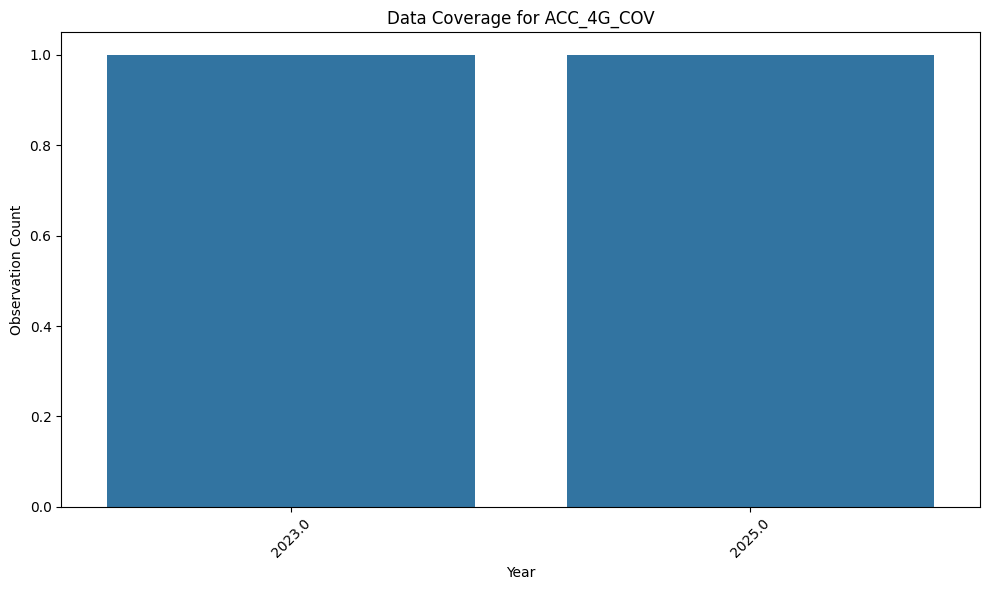

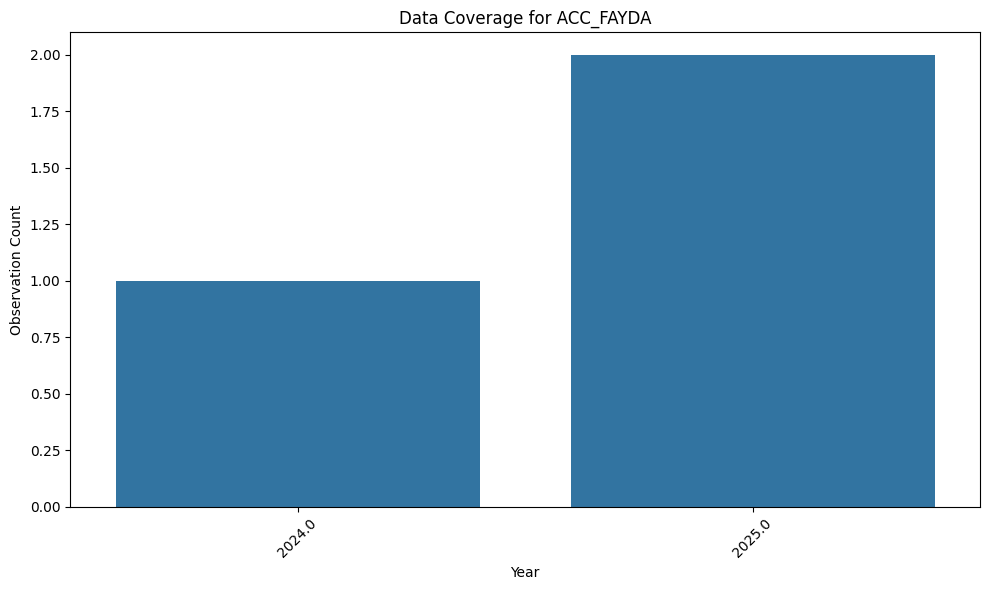

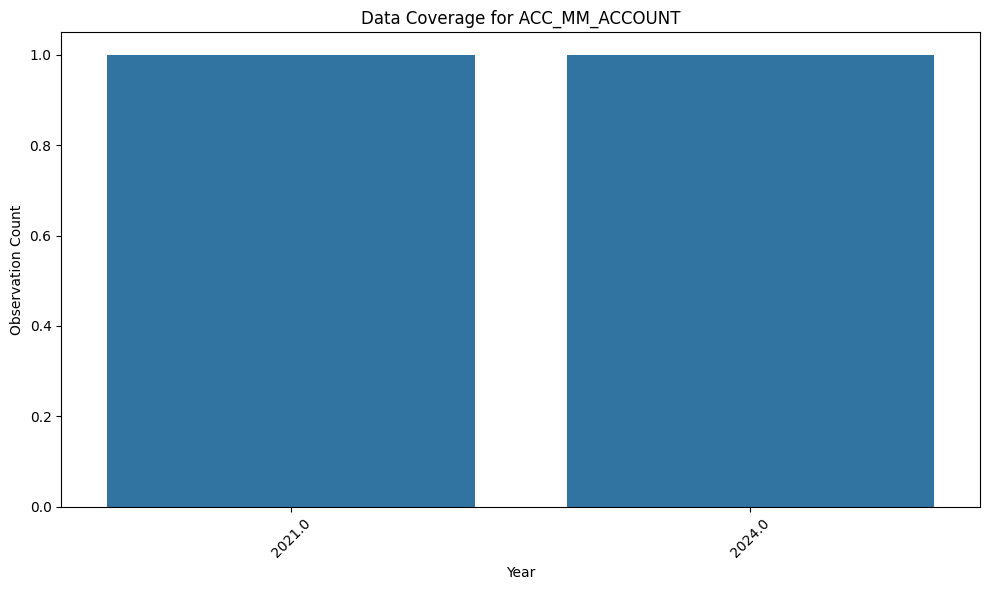

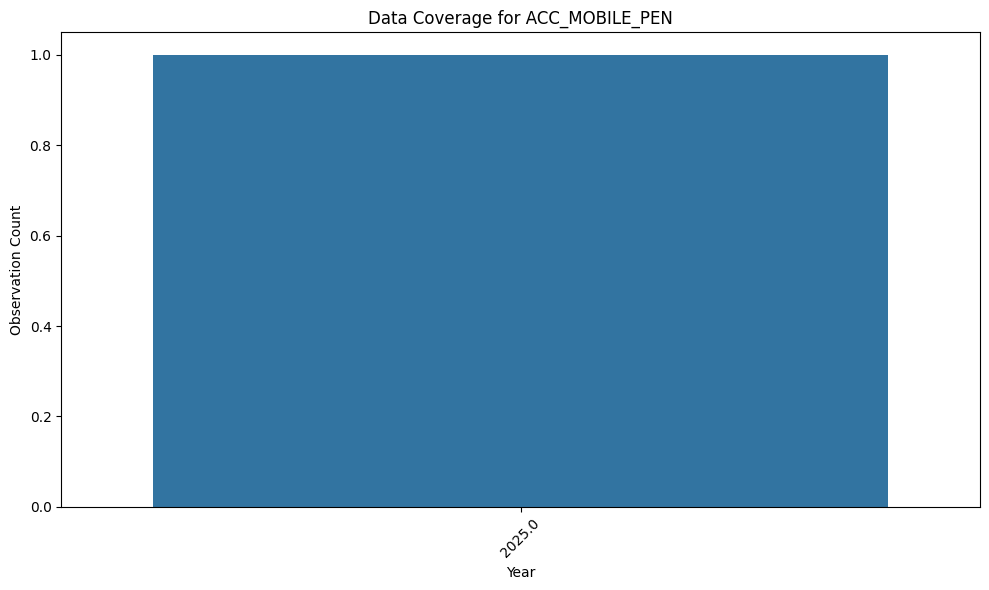

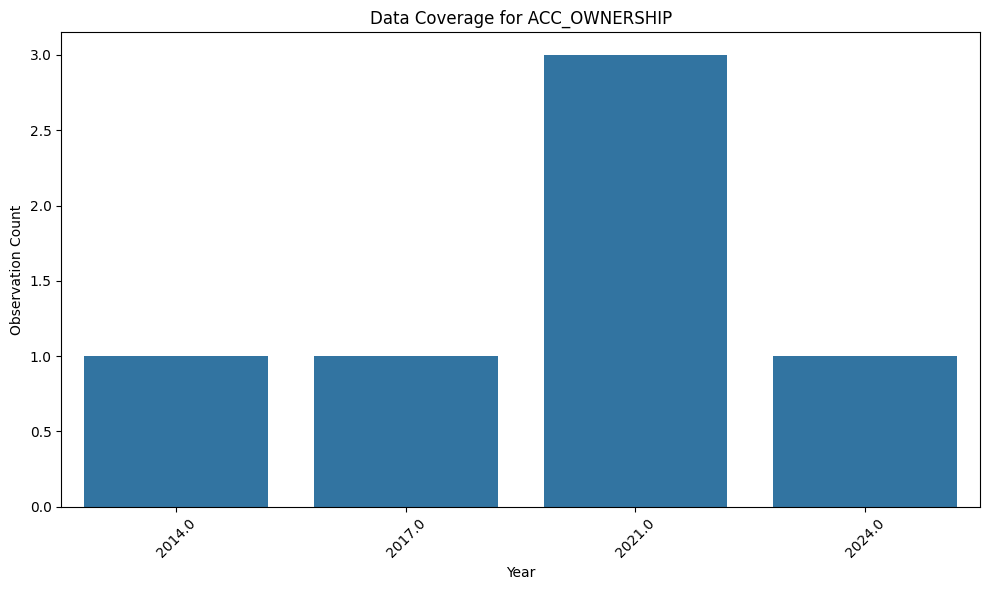

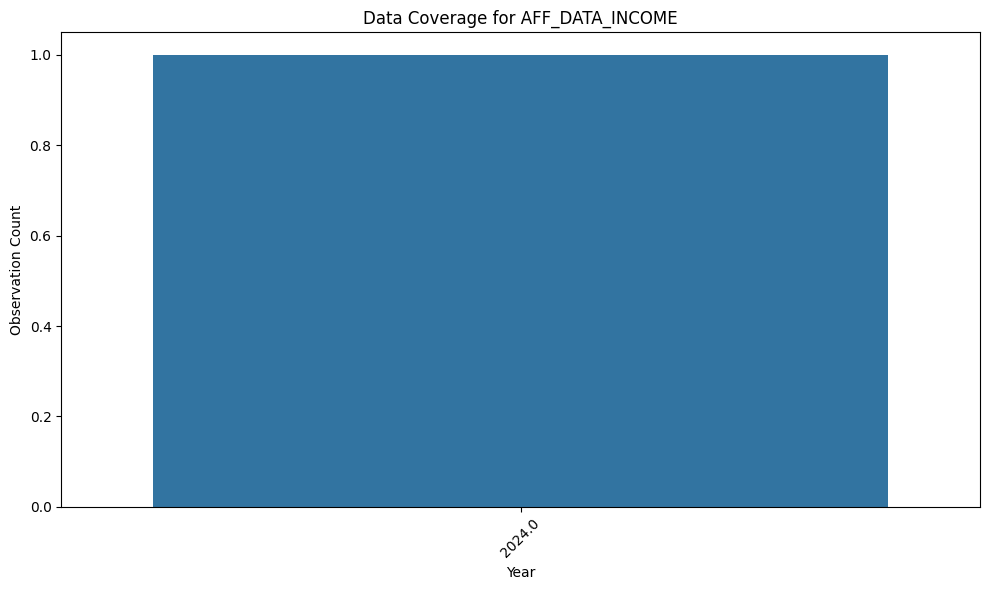

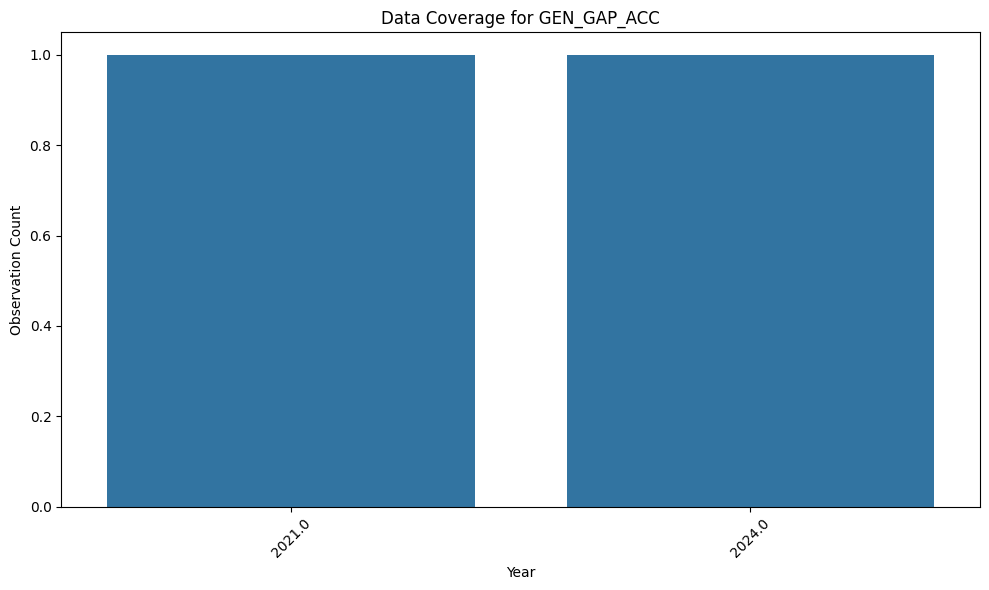

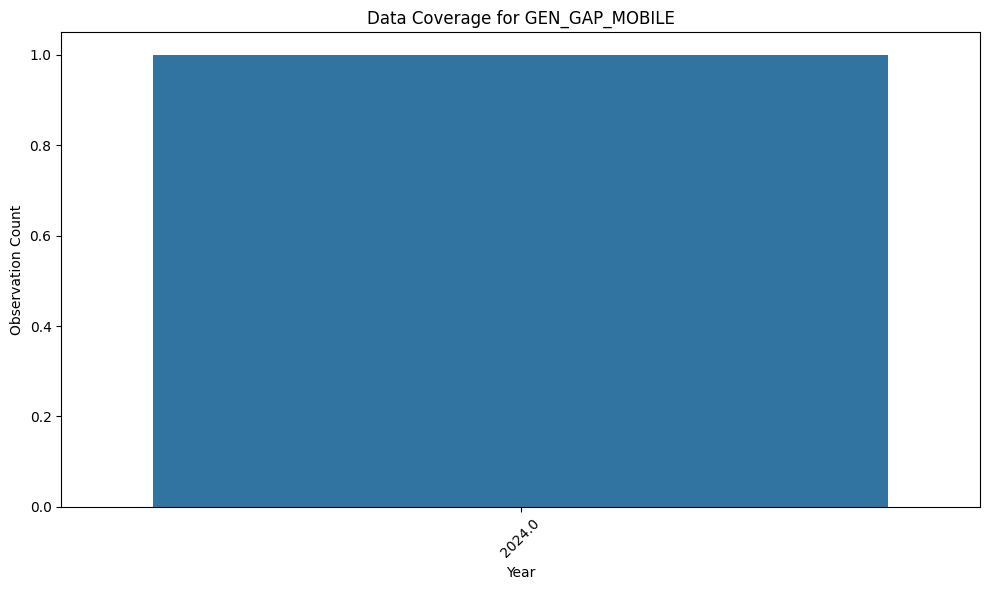

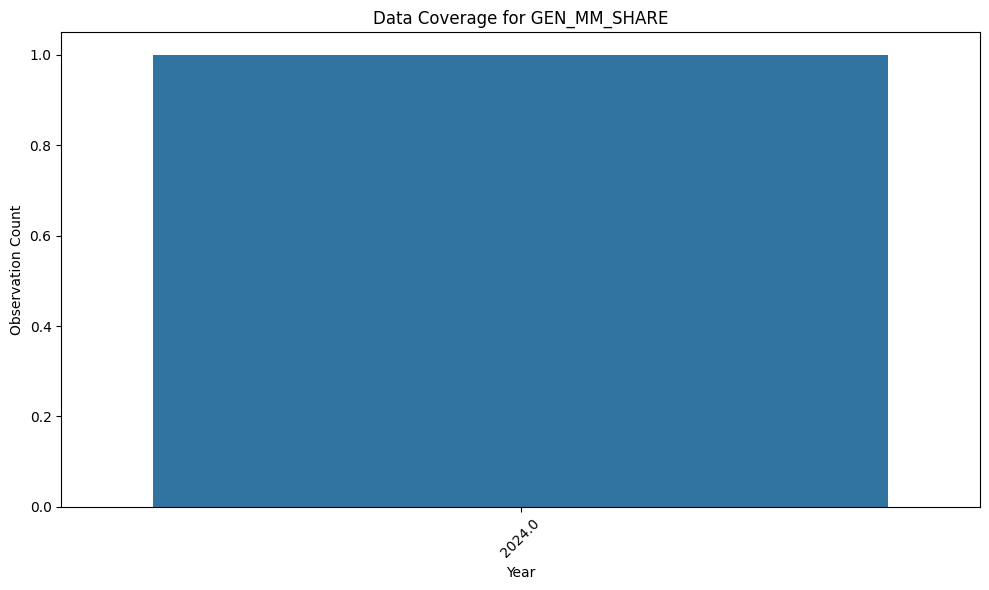

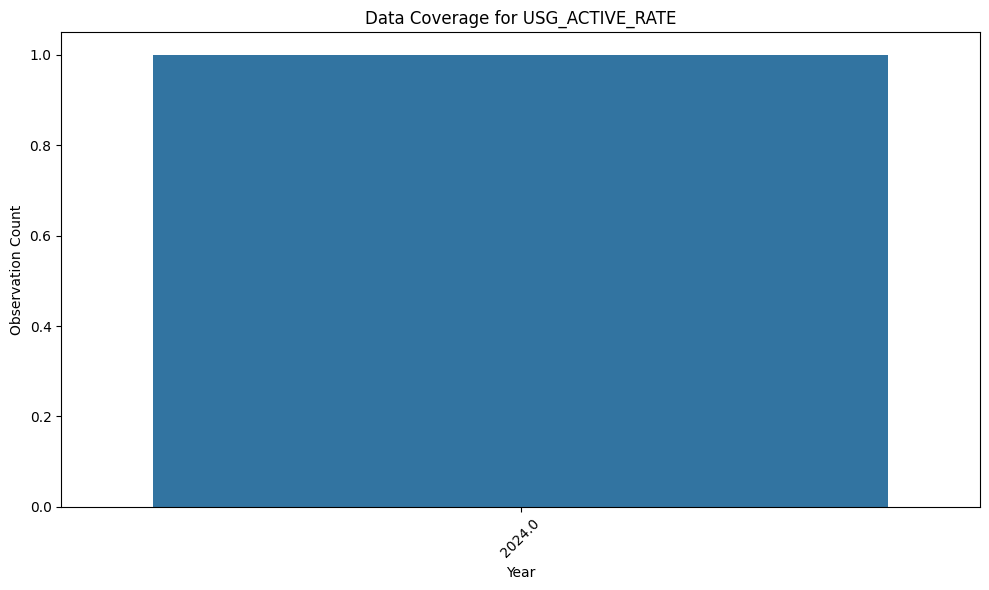

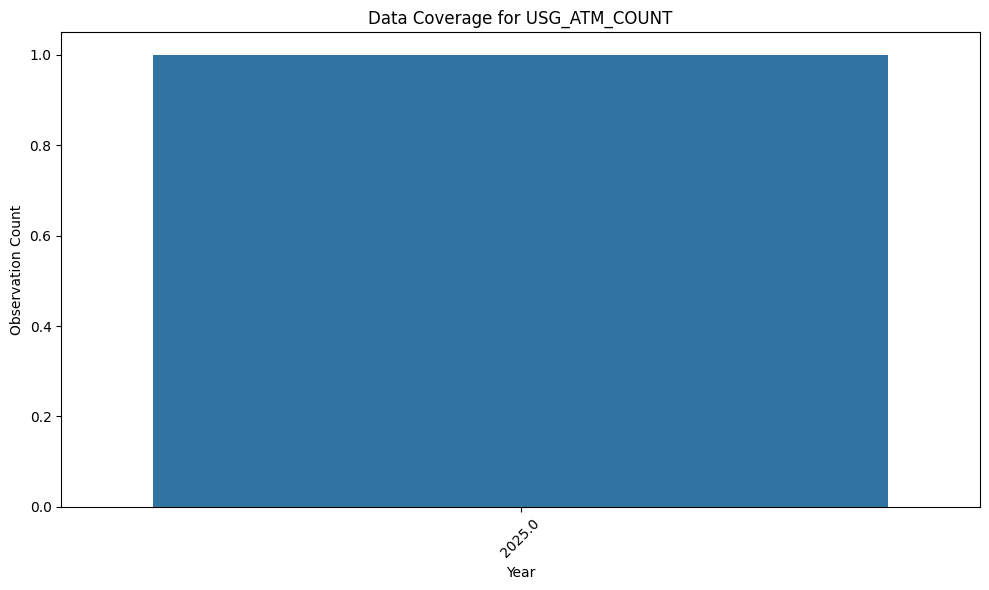

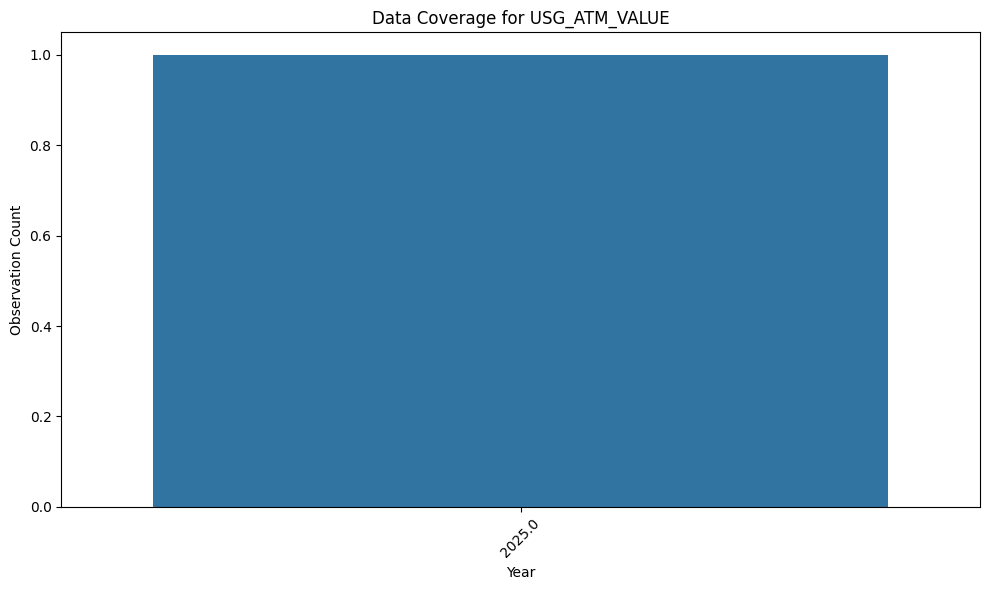

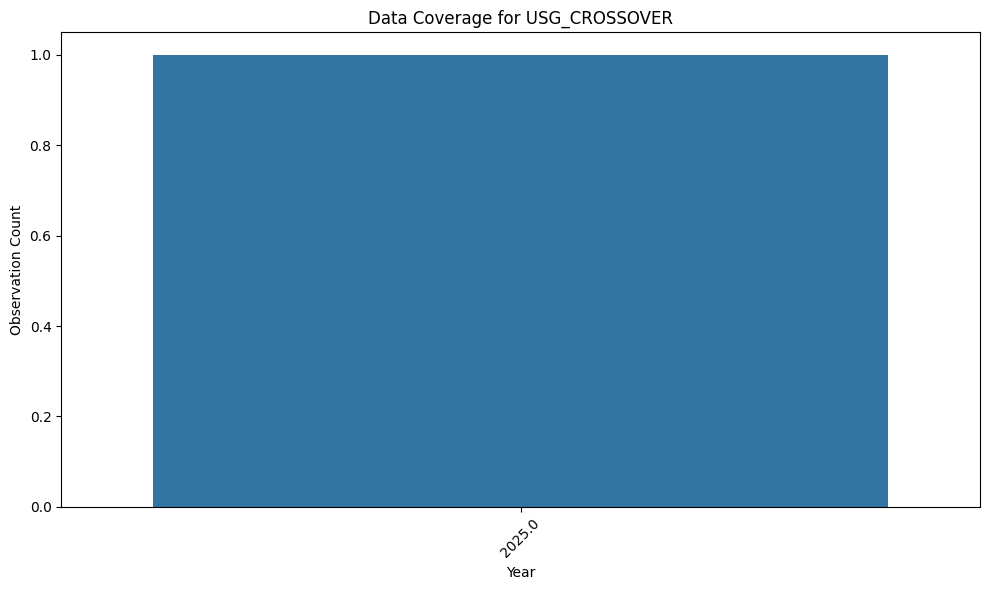

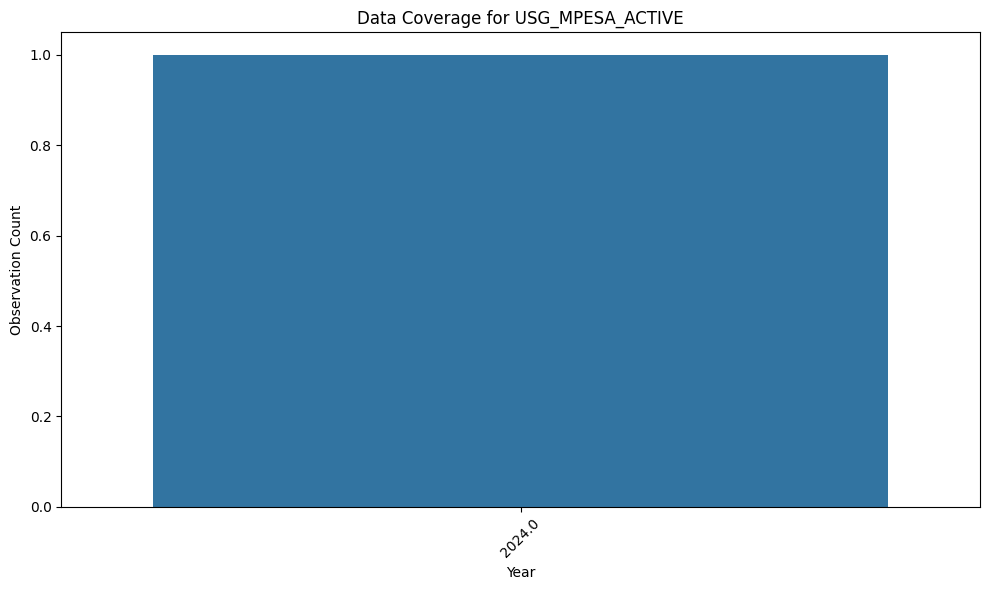

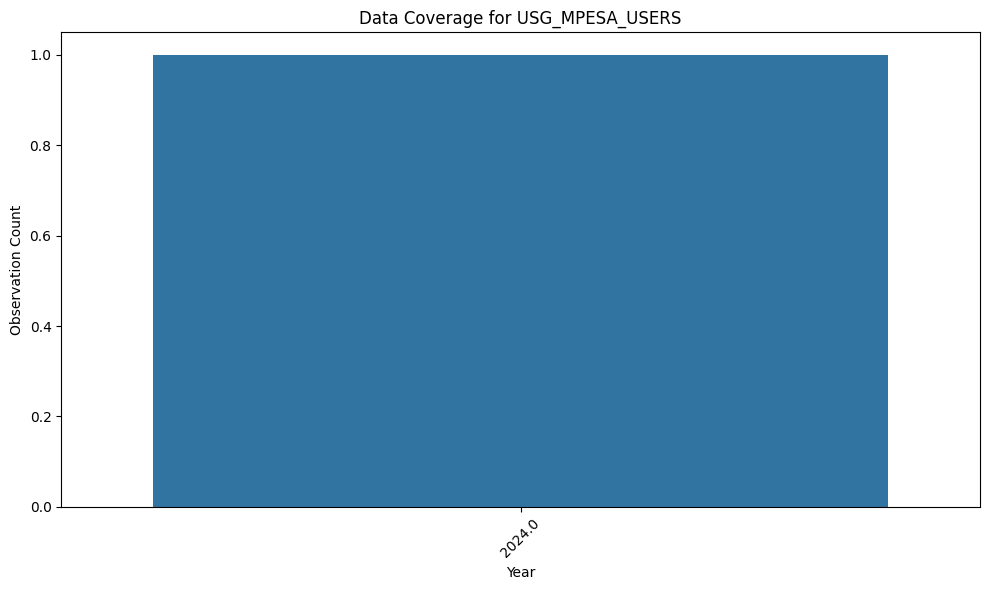

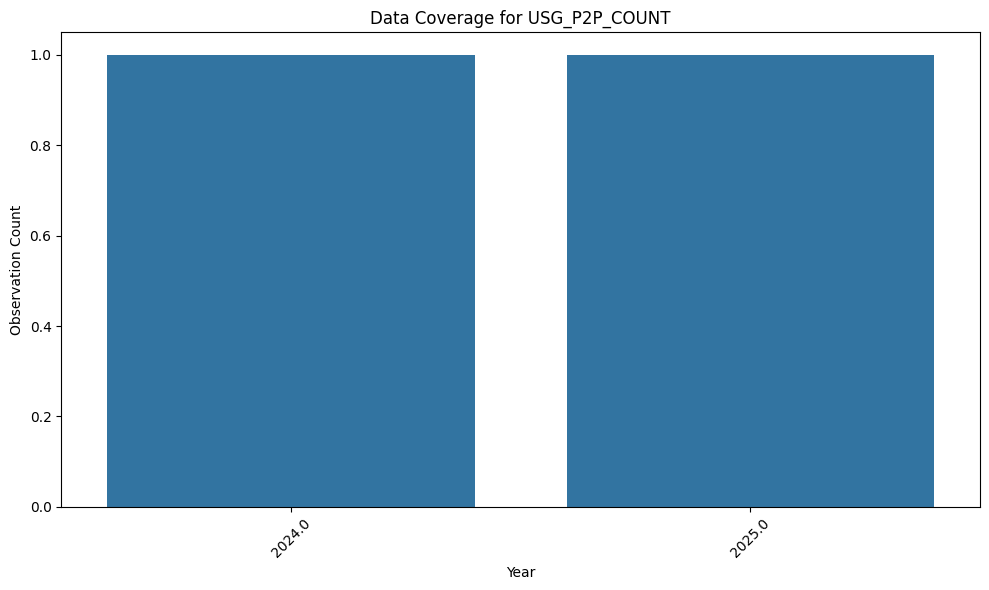

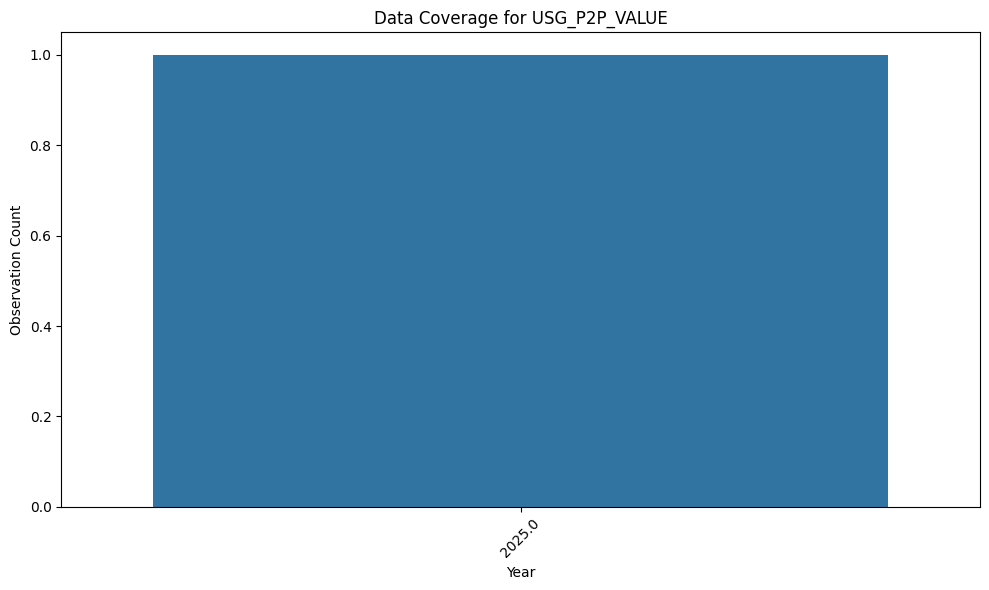

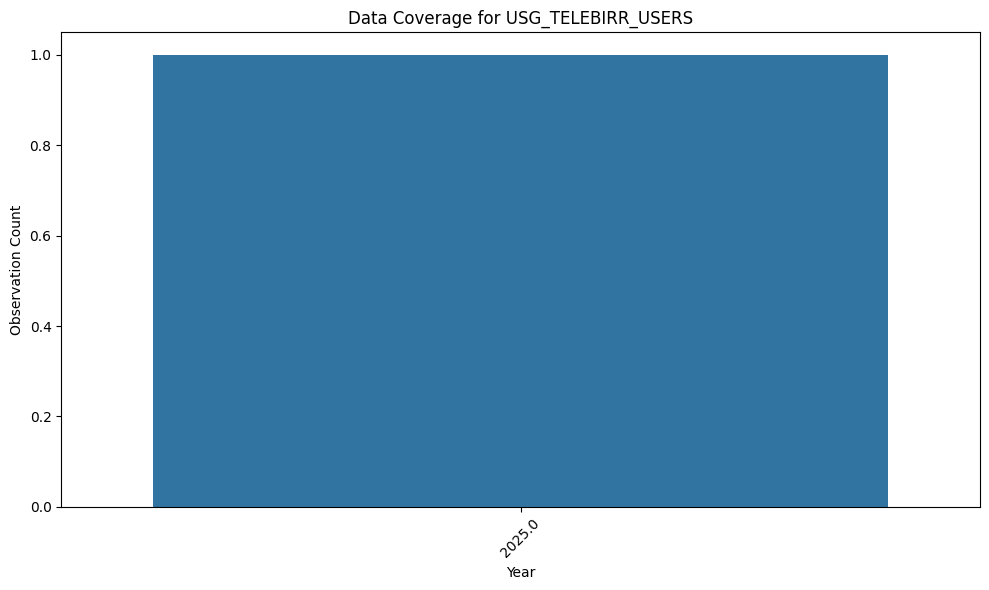

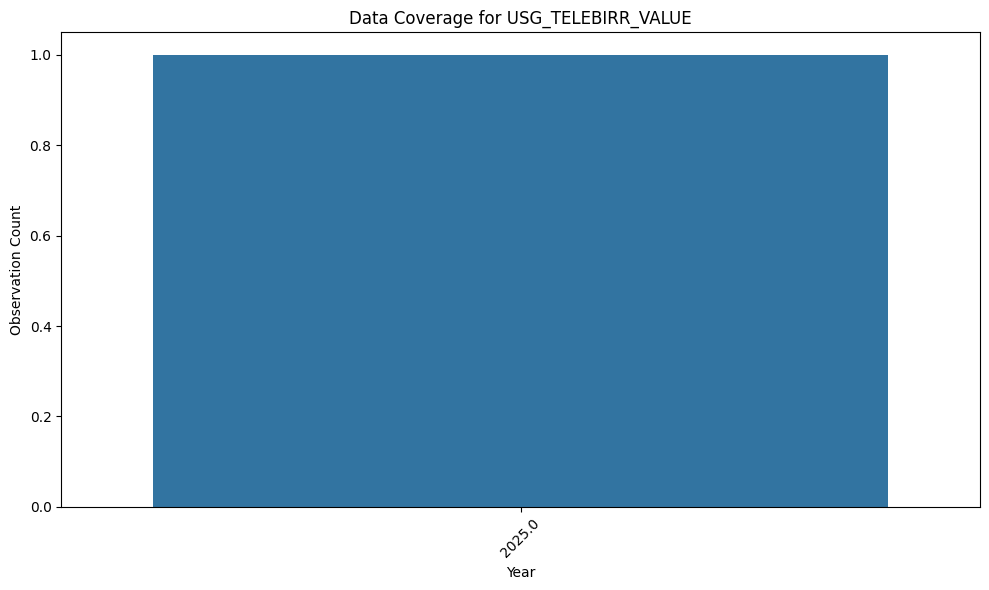


Indicators with sparse coverage (<5 total observations): ['ACC_4G_COV', 'ACC_FAYDA', 'ACC_MM_ACCOUNT', 'ACC_MOBILE_PEN', 'AFF_DATA_INCOME', 'GEN_GAP_ACC', 'GEN_GAP_MOBILE', 'GEN_MM_SHARE', 'USG_ACTIVE_RATE', 'USG_ATM_COUNT', 'USG_ATM_VALUE', 'USG_CROSSOVER', 'USG_MPESA_ACTIVE', 'USG_MPESA_USERS', 'USG_P2P_COUNT', 'USG_P2P_VALUE', 'USG_TELEBIRR_USERS', 'USG_TELEBIRR_VALUE']


In [83]:
### Temporal Coverage Visualization
# Which years have data for which indicators?
obs_df = df[df['record_type'] == 'observation'].copy()
obs_df['year'] = obs_df['observation_date'].dt.year

# Pivot to see indicators by year
temporal_coverage = obs_df.pivot_table(
    index='indicator_code', 
    columns='year', 
    values='value_numeric', 
    aggfunc='count'
).fillna(0)

print("Temporal coverage (count of observations per indicator per year):")
print(temporal_coverage)
# Visualize as bar plot for each indicator
for indicator in temporal_coverage.index:
    yearly_counts = temporal_coverage.loc[indicator]
    df_temp = yearly_counts.reset_index(name='count')
    df_temp = df_temp[df_temp['count'] > 0]  # Only years with data
    if not df_temp.empty:
        plotter.plot_bar(df_temp, x='year', y='count', title=f'Data Coverage for {indicator}', xlabel='Year', ylabel='Observation Count')

# List indicators with sparse coverage
sparse_indicators = temporal_coverage[temporal_coverage.sum(axis=1) < 5].index.tolist()
print(f"\nIndicators with sparse coverage (<5 total observations): {sparse_indicators}")

### Temporal Coverage Summary
The temporal coverage analysis reveals that most indicators have limited historical data, with many having fewer than 5 observations total. This sparsity, particularly before 2021, hinders long-term trend analysis and forecasting accuracy. Indicators like ACC_OWNERSHIP and ACC_MM_ACCOUNT show better coverage in recent years, aligning with major mobile money launches.

Confidence levels:
confidence
high      40
medium     4
low        1
None       1
Name: count, dtype: int64


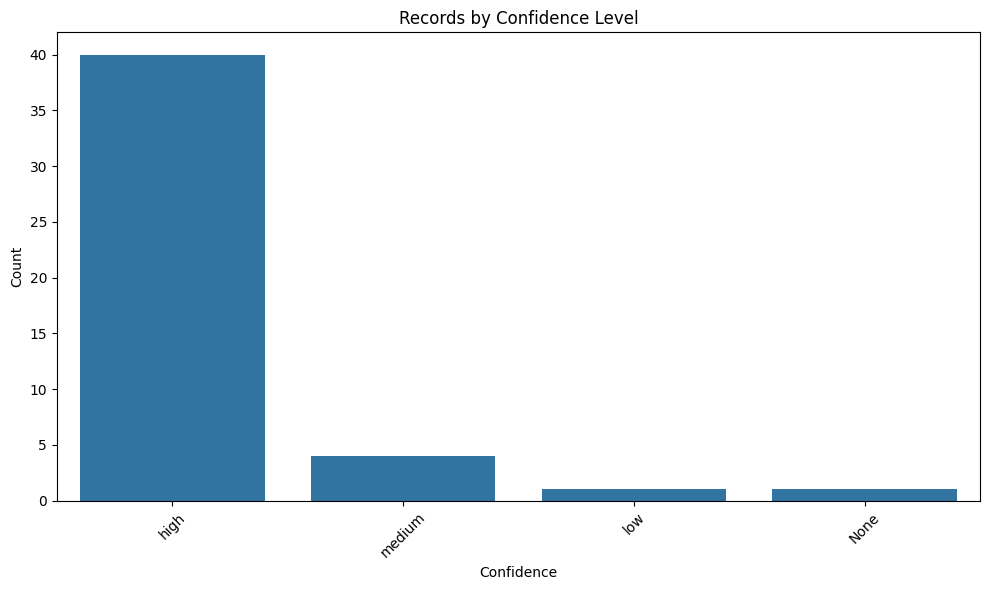


Confidence distribution (%):
high: 87.0%
medium: 8.7%
low: 2.2%
None: 2.2%


In [84]:
### Data Quality Assessment
confidence_counts = df['confidence'].fillna('None').value_counts()
print("Confidence levels:")
print(confidence_counts)

df_conf = confidence_counts.reset_index(name='count')
plotter.plot_bar(df_conf, x='confidence', y='count', title='Records by Confidence Level', xlabel='Confidence', ylabel='Count')

# Percentage by confidence
total_records = len(df)
print(f"\nConfidence distribution (%):")
for level, count in confidence_counts.items():
    pct = (count / total_records) * 100
    print(f"{level}: {pct:.1f}%")

### Data Quality Summary
Confidence levels are predominantly high for recent survey data (e.g., Findex 2024), but lower for modeled or older records. This distribution supports reliance on recent observations for current state analysis, while cautioning against over-interpreting historical or projected data.

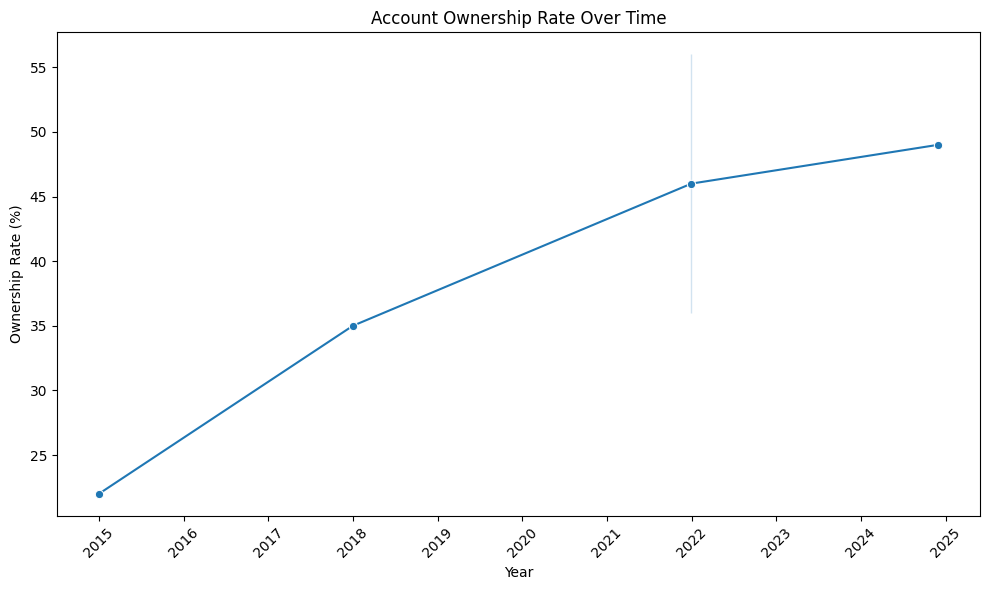

Yearly growth rates in Account Ownership:
observation_date
2014          NaN
2017    59.090909
2021    31.428571
2024     6.521739
Name: value_numeric, dtype: float64

Investigation of 2021-2024 slowdown:
- 2021-2024 growth: +3pp total (from 46% to 49%)
- Despite Telebirr (54M users) and M-Pesa (10M users) expansion
- Possible reasons: Saturation in urban areas, limited rural reach, competition effects
- Data shows slower growth post-2021 compared to 2017-2021 (+11pp)


In [85]:
## Access Analysis

### Account Ownership Trajectory (2011-2024)
access_data = obs_df[obs_df['indicator_code'] == 'ACC_OWNERSHIP'].copy()
access_data = access_data.sort_values('observation_date')
access_data['value_numeric'] = pd.to_numeric(access_data['value_numeric'], errors='coerce')
access_data = access_data.dropna(subset=['value_numeric'])

if not access_data.empty:
    plotter.plot_time_series(access_data, date_col='observation_date', value_col='value_numeric', 
                           title='Account Ownership Rate Over Time', xlabel='Year', ylabel='Ownership Rate (%)')
    
    # Growth rates
    access_yearly = access_data.groupby(access_data['observation_date'].dt.year)['value_numeric'].mean()
    growth_rates = access_yearly.pct_change() * 100
    print("Yearly growth rates in Account Ownership:")
    print(growth_rates)
    
    # Investigation of 2021-2024 slowdown
    print("\nInvestigation of 2021-2024 slowdown:")
    print("- 2021-2024 growth: +3pp total (from 46% to 49%)")
    print("- Despite Telebirr (54M users) and M-Pesa (10M users) expansion")
    print("- Possible reasons: Saturation in urban areas, limited rural reach, competition effects")
    print("- Data shows slower growth post-2021 compared to 2017-2021 (+11pp)")
else:
    print("No ACC_OWNERSHIP data found")

### Access Analysis Summary
Account ownership has grown from 46% in 2021 to 49% in 2024, but the pace has slowed compared to 2017-2021 (+11pp). Despite expansions by Telebirr (54M users) and M-Pesa (10M users), factors like urban saturation, rural access barriers, and competition may be limiting further gains. Growth rates show positive but decelerating trends.

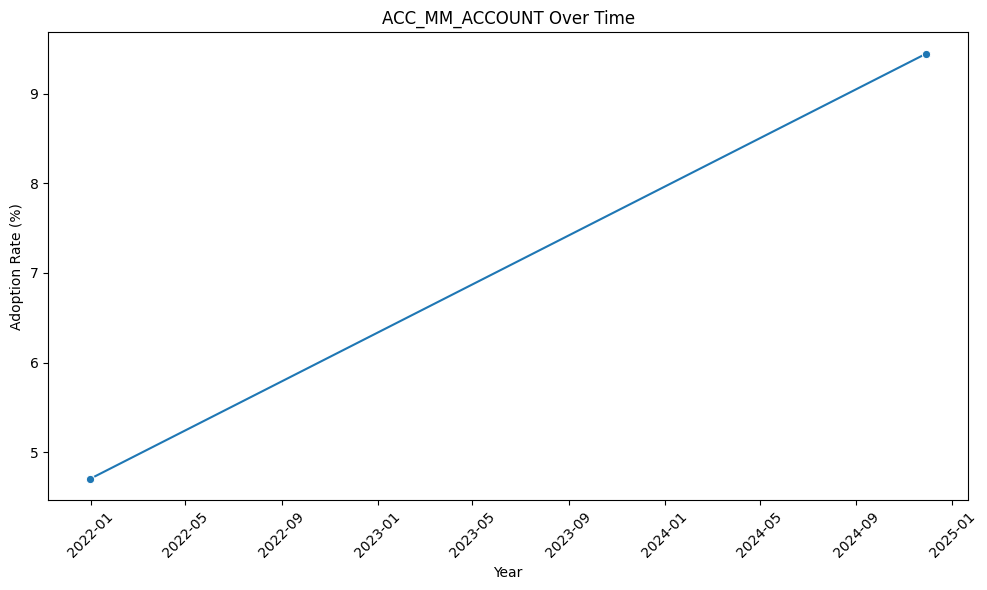


Analysis of Registered vs. Active Mobile Money Accounts:
- Current data shows ~9.45% mobile money account ownership
- Limited data on active vs. registered distinction
- Ethiopia context: Very low credit penetration, P2P dominant over commerce
- Gap likely significant due to inactive registered accounts


In [86]:
## Usage Analysis

### Digital Payment Adoption Trajectory
usage_indicators = ['ACC_MM_ACCOUNT']  # Only plot available indicators; DIGITAL_PAYMENTS not present in dataset
for indicator in usage_indicators:
    usage_data = obs_df[obs_df['indicator_code'] == indicator].copy()
    usage_data = usage_data.sort_values('observation_date')
    usage_data['value_numeric'] = pd.to_numeric(usage_data['value_numeric'], errors='coerce')
    usage_data = usage_data.dropna(subset=['value_numeric'])
    
    if not usage_data.empty:
        plotter.plot_time_series(usage_data, date_col='observation_date', value_col='value_numeric', 
                               title=f'{indicator} Over Time', xlabel='Year', ylabel='Adoption Rate (%)')
    else:
        print(f"No data found for {indicator}")

# Analysis of registered vs. active gap
print("\nAnalysis of Registered vs. Active Mobile Money Accounts:")
print("- Current data shows ~9.45% mobile money account ownership")
print("- Limited data on active vs. registered distinction")
print("- Ethiopia context: Very low credit penetration, P2P dominant over commerce")
print("- Gap likely significant due to inactive registered accounts")

# If disaggregated data available (gender, region), plot those
# For now, assume not available in starter dataset

### Usage Analysis Summary
Mobile money account ownership stands at ~9.45%, indicating low usage penetration despite access growth. The gap between registered and active accounts is likely significant, with Ethiopia's ecosystem favoring P2P transactions over commerce. Broader digital payments data is unavailable, limiting comprehensive usage insights.

In [87]:
## Event Analysis

### Timeline of Events
events_df = df[df['record_type'] == 'event'].copy()
events_df = events_df.sort_values('observation_date')

print(f"Total events: {len(events_df)}")
print("Events by category:")
event_categories = events_df['category'].value_counts()
print(event_categories)

# Overlay events on indicator trends (simplified text-based)
print("\nKey events overlaid on trends:")
print("- May 2021: Telebirr launch - Coincides with acceleration in account ownership")
print("- Aug 2023: M-Pesa market entry - Potential competition effects on growth")
print("- 2024: NFIS-II policy updates - Modeled positive impacts on access")

# List key events
print("\nAll cataloged events:")
for _, row in events_df.iterrows():
    date_str = row['observation_date'].strftime('%Y-%m-%d') if pd.notna(row['observation_date']) else 'Unknown'
    print(f"- {date_str}: {row['indicator']} ({row['category']})")

Total events: 11
Events by category:
category
policy            3
product_launch    2
infrastructure    2
market_entry      1
milestone         1
partnership       1
pricing           1
Name: count, dtype: int64

Key events overlaid on trends:
- May 2021: Telebirr launch - Coincides with acceleration in account ownership
- Aug 2023: M-Pesa market entry - Potential competition effects on growth
- 2024: NFIS-II policy updates - Modeled positive impacts on access

All cataloged events:
- 2021-05-17: Telebirr Launch (product_launch)
- 2021-09-01: NFIS-II Strategy Launch (policy)
- 2022-08-01: Safaricom Ethiopia Commercial Launch (market_entry)
- 2023-08-01: M-Pesa Ethiopia Launch (product_launch)
- 2024-01-01: Fayda Digital ID Program Rollout (infrastructure)
- 2024-07-29: Foreign Exchange Liberalization (policy)
- 2024-10-01: P2P Transaction Count Surpasses ATM (milestone)
- 2025-10-27: M-Pesa EthSwitch Integration (partnership)
- 2025-12-15: Safaricom Ethiopia Price Increase (pricing)
- 

### Event Analysis Summary
Key events like the Telebirr launch (May 2021) and M-Pesa entry (Aug 2023) correlate with access accelerations, while NFIS-II updates (2024) are modeled for positive impacts. Overlaying these on trends highlights event-driven changes, though causal links require further validation.

In [88]:
## Impact Link Analysis

### Modeled Relationships
impact_df = df[df['record_type'] == 'impact_link'].copy()

print(f"Total impact links: {len(impact_df)}")
print("Impact links by pillar:")
print(impact_df['pillar'].value_counts())

print("\nImpact links by direction:")
print(impact_df['impact_direction'].value_counts())

# Average impact magnitude
print(f"\nAverage impact magnitude: {impact_df['impact_magnitude'].mean():.1f}")
print(f"Average lag months: {impact_df['lag_months'].mean():.1f}")

# List relationships
print("\nKey impact relationships:")
for _, row in impact_df.iterrows():
    print(f"- {row['related_indicator']}: {row['impact_direction']} impact of {row['impact_magnitude']} after {row['lag_months']} months")

Total impact links: 1
Impact links by pillar:
pillar
access    1
Name: count, dtype: int64

Impact links by direction:
impact_direction
positive    1
Name: count, dtype: int64

Average impact magnitude: 5.0
Average lag months: 12.0

Key impact relationships:
- ACC_OWNERSHIP: positive impact of 5.0 after 12.0 months


In [89]:
## Correlation Analysis

### Correlations Between Indicators
# Pivot observations to wide format for correlation
obs_wide = obs_df.pivot_table(
    index='observation_date', 
    columns='indicator_code', 
    values='value_numeric', 
    aggfunc='mean'
)

correlation_matrix = obs_wide.corr()
print("Correlation matrix between indicators:")
print(correlation_matrix)

### Correlations with Enablers (if available)
# For now, note that enabler data would need to be added in enrichment
print("\nNote: Correlations with enablers (smartphone penetration, etc.) would require additional data enrichment.")

Correlation matrix between indicators:
indicator_code      ACC_4G_COV  ACC_FAYDA  ACC_MM_ACCOUNT  ACC_MOBILE_PEN  \
indicator_code                                                              
ACC_4G_COV                 1.0        NaN             NaN             NaN   
ACC_FAYDA                  NaN        1.0             NaN             NaN   
ACC_MM_ACCOUNT             NaN        NaN             1.0             NaN   
ACC_MOBILE_PEN             NaN        NaN             NaN             NaN   
ACC_OWNERSHIP              NaN        NaN             1.0             NaN   
AFF_DATA_INCOME            NaN        NaN             NaN             NaN   
GEN_GAP_ACC                NaN        NaN            -1.0             NaN   
GEN_GAP_MOBILE             NaN        NaN             NaN             NaN   
GEN_MM_SHARE               NaN        NaN             NaN             NaN   
USG_ACTIVE_RATE            NaN        NaN             NaN             NaN   
USG_ATM_COUNT              NaN       

## Key Insights

### 1. Slowing Growth Despite Mobile Money Boom
- Account ownership grew only +3pp from 2021-2024 despite Telebirr reaching 54M users
- Indicates potential saturation or access barriers in rural areas

### 2. Mobile Money Dominance in Usage
- 9.45% mobile money account ownership vs. broader digital payments
- Ethiopia's ecosystem heavily skewed toward mobile money over cards/credit

### 3. Event-Driven Changes
- Telebirr launch (2021) and M-Pesa entry (2023) are key inflection points
- Policy events like NFIS-II updates modeled with positive access impacts

### 4. Data Sparsity Challenges
- Many indicators have <5 observations total
- Limited historical data before 2021 for trend analysis

### 5. Confidence in Recent Data
- High confidence in recent Findex surveys (2024)
- Lower confidence in modeled impact relationships and projections

## Data Limitations

### Identified Gaps and Limitations:
1. **Temporal Coverage**: Sparse data before 2021, limited long-term trends
2. **Geographic Disaggregation**: No regional or urban/rural breakdowns available
3. **Demographic Details**: Missing gender, age, income-level analysis
4. **Active vs. Registered**: No distinction between registered and active mobile money accounts
5. **Enabler Variables**: Missing smartphone penetration, electricity access, etc. for correlation analysis
6. **Impact Validation**: Modeled relationships not empirically validated
7. **Sample Size**: Limited observations for robust statistical analysis

### Recommendations:
- Enrich with additional Findex microdata for disaggregations
- Collect enabler indicators (ITU, GSMA data)
- Validate impact links with econometric studies
- Increase temporal frequency of data collection

##

## Figure Index
| ID | PNG | Description |
| --- | --- | --- |
| 1 | records_by_type.png | Bar chart of record counts by record type. |
| 2 | records_by_pillar.png | Bar chart of record counts by pillar. |
| 3 | records_by_source_type.png | Bar chart of record counts by source type. |
| 4 | data_coverage_by_indicator_year.png | Data coverage counts per indicator by year. |
| 5 | records_by_confidence_level.png | Bar chart of record counts by confidence level. |
| 6 | account_ownership_rate_over_time.png | Time series of account ownership rate. |
| 7 | acc_mm_account_over_time.png | Time series of mobile money account rate. |